In [1]:
import torch
print("CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("Device name:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("Could not get device name:", e)
else:
    print("Running on CPU")


CUDA available? True
Device name: Tesla T4


In [2]:
# Install required packages
!pip install --upgrade pip
!pip install torch torchvision torchaudio
!pip install transformers datasets soundfile librosa accelerate scipy matplotlib seaborn psutil

# Install torchcodec and ensure version compatible with torch
# For torch version ~2.8.x use torchcodec 0.7.x (see compatibility)
!pip install torchcodec==0.7.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.7 MB/s  0:00:00


In [3]:
import os
import torch
import numpy as np
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from datasets import load_dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [4]:
dataset = load_dataset("DarshanaS/IndicAccentDb")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

IndicAccentDB.zip:   0%|          | 0.00/3.20G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8116 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 8116
    })
})



Inspecting first 5 samples:
Sample 1: label=0, rate=16000, shape=(43520,)


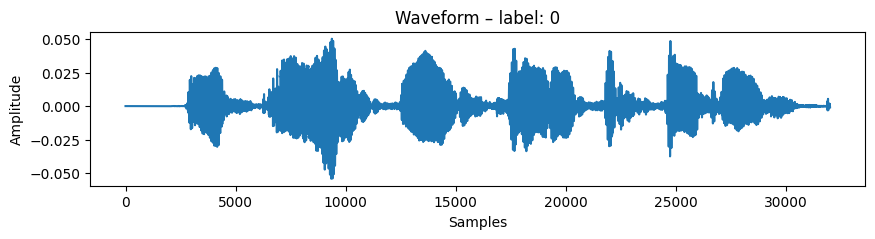

Sample 2: label=0, rate=16000, shape=(36800,)


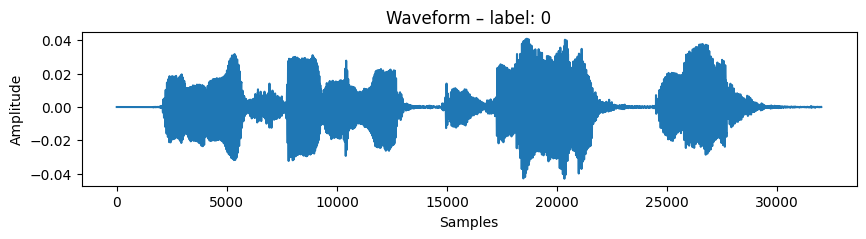

Sample 3: label=0, rate=16000, shape=(40640,)


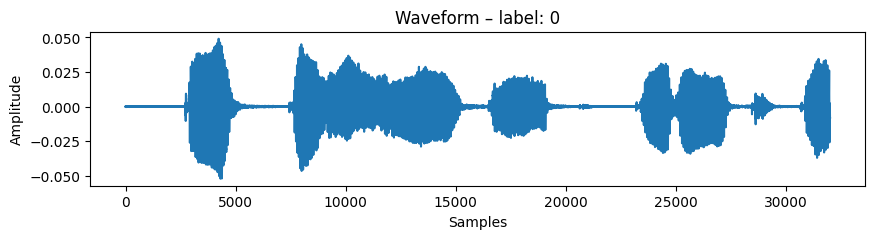

Sample 4: label=0, rate=16000, shape=(48000,)


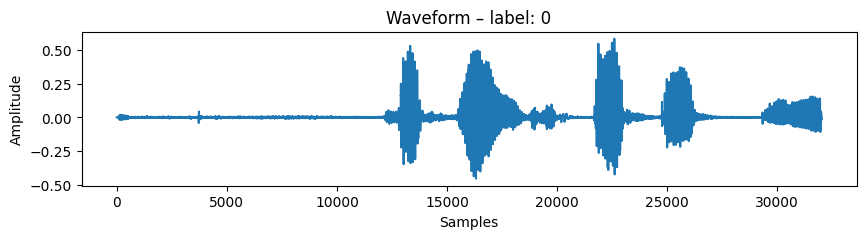

Sample 5: label=0, rate=16000, shape=(47040,)


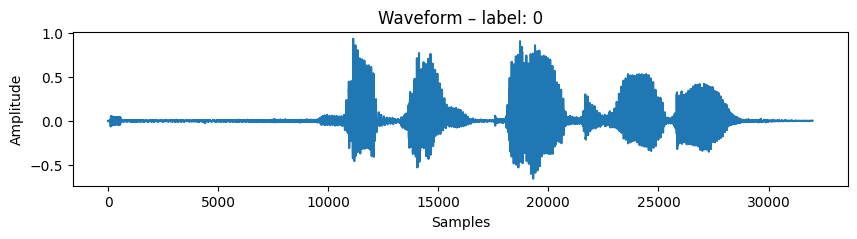

In [5]:
subset_count = 5
print(f"\nInspecting first {subset_count} samples:")
for i, entry in enumerate(dataset['train'].select(range(subset_count))):
    # load audio from the dataset's audio feature
    audio_data = entry['audio']
    wav = audio_data['array']
    sr = audio_data['sampling_rate']

    # convert to mono if stereo (although datasets audio feature usually returns mono)
    if wav.ndim == 2:
        wav = wav.mean(axis=1)

    # resample to 16kHz if needed (datasets audio feature can do this on load, but checking just in case)
    target_sr = 16000
    if sr != target_sr:
        # Note: The datasets library can handle resampling directly when loading the dataset
        # or when accessing the audio feature. This manual resampling might be redundant
        # depending on how the dataset was loaded and configured.
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    print(f"Sample {i+1}: label={entry['label']}, rate={sr}, shape={wav.shape}")
    plt.figure(figsize=(10,2))
    plt.plot(wav[:sr*2])
    plt.title(f"Waveform – label: {entry['label']}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()

In [6]:
from collections import Counter

# Sample a manageable subset for speed
subset_for_stats = dataset['train'].select(range(100))
labels = [entry['label'] for entry in subset_for_stats]
label_counts = Counter(labels)
print("Label counts (first 100 entries):", label_counts)

durations = []
for entry in subset_for_stats:
    # Access audio data and sampling rate directly from the loaded dataset entry
    wav = entry['audio']['array']
    sr = entry['audio']['sampling_rate']

    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    durations.append(len(wav)/sr)

durations = np.array(durations)
print(f"Durations – avg: {durations.mean():.2f}s, min: {durations.min():.2f}s, max: {durations.max():.2f}s")

usage = psutil.virtual_memory()
print(f"RAM usage: {usage.used/1024**3:.2f} GB used, {usage.available/1024**3:.2f} GB available")

Label counts (first 100 entries): Counter({0: 100})
Durations – avg: 4.46s, min: 0.80s, max: 14.20s
RAM usage: 1.85 GB used, 10.51 GB available


In [7]:
import torch
import librosa
from tqdm import tqdm
import numpy as np

# Example: MFCC extraction
def extract_mfcc(wav, sr, n_mfcc=40, hop_length=512, n_fft=2048, max_len=None):
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc,
                                hop_length=hop_length, n_fft=n_fft)

    if max_len is not None:
        if mfcc.shape[1] < max_len:
            # Pad with zeros if shorter than max_len
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif mfcc.shape[1] > max_len:
            # Truncate if longer than max_len
            mfcc = mfcc[:, :max_len]
    return mfcc

# Determine a suitable maximum length for padding
# You might want to calculate this based on the distribution of durations in your dataset
# For simplicity, let's use a fixed value or calculate from a subset
subset_for_len = dataset['train'].select(range(1000)) # Use a larger subset for a more representative max length
max_mfcc_len = 0
for entry in subset_for_len:
    wav = entry['audio']['array']
    sr  = entry['audio']['sampling_rate']
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    target_sr = 16000
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    mfcc_feat = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=40, hop_length=512, n_fft=2048)
    if mfcc_feat.shape[1] > max_mfcc_len:
        max_mfcc_len = mfcc_feat.shape[1]

print(f"Maximum MFCC length found in subset: {max_mfcc_len}")


features = []
labels   = []
for entry in tqdm(dataset['train']):
    wav = entry['audio']['array']
    sr  = entry['audio']['sampling_rate']
    # convert stereo to mono if needed
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    # resample to target if needed
    target_sr = 16000
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    # extract MFCC and pad
    mfcc_feat = extract_mfcc(wav, sr, max_len=max_mfcc_len)
    features.append(mfcc_feat.flatten())
    labels.append(entry['label'])

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)
print("Feature matrix shape:", X.shape, "Labels shape:", y.shape)

Maximum MFCC length found in subset: 701


100%|██████████| 8116/8116 [27:25<00:00,  4.93it/s]


Feature matrix shape: (8116, 28040) Labels shape: (8116,)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train.shape, "Validation size:", X_val.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

Train size: (6492, 28040) Validation size: (1624, 28040)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

input_dim  = X_train.shape[1]
num_labels = len(np.unique(y))
model      = SimpleMLP(input_dim, hidden_dim=128, num_classes=num_labels).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr=0.001)

epochs     = 10
batch_size = 32

for epoch in range(epochs):
    model.train()
    perm = np.random.permutation(len(X_train))
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        idx     = perm[i:i+batch_size]
        batch_x = torch.tensor(X_train[idx], dtype=torch.float32).to(device)
        batch_y = torch.tensor(y_train[idx], dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss    = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(X_train)
    print(f"Epoch {epoch+1}/{epochs} — Training loss: {train_loss:.4f}")

    model.eval()
    with torch.no_grad():
        val_x    = torch.tensor(X_val, dtype=torch.float32).to(device)
        val_y    = torch.tensor(y_val, dtype=torch.long).to(device)
        val_logits = model(val_x)
        val_preds  = torch.argmax(val_logits, axis=1).cpu().numpy()
    val_acc = accuracy_score(y_val, val_preds)
    print(f"Validation accuracy: {val_acc:.4f}")

print("Classification report:")
print(classification_report(y_val, val_preds))
print("Confusion matrix:")
print(confusion_matrix(y_val, val_preds))

Epoch 1/10 — Training loss: 2.1480
Validation accuracy: 0.9760
Epoch 2/10 — Training loss: 0.2908
Validation accuracy: 0.9877
Epoch 3/10 — Training loss: 0.0969
Validation accuracy: 0.9877
Epoch 4/10 — Training loss: 0.0097
Validation accuracy: 0.9871
Epoch 5/10 — Training loss: 0.0208
Validation accuracy: 0.9877
Epoch 6/10 — Training loss: 0.1281
Validation accuracy: 0.9852
Epoch 7/10 — Training loss: 0.1421
Validation accuracy: 0.9889
Epoch 8/10 — Training loss: 0.0357
Validation accuracy: 0.9877
Epoch 9/10 — Training loss: 1.9449
Validation accuracy: 0.9815
Epoch 10/10 — Training loss: 0.0856
Validation accuracy: 0.9815
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       359
           1       0.98      1.00      0.99        60
           2       0.99      0.95      0.97       166
           3       0.99      0.99      0.99       337
           4       0.99      0.97      0.98       334
           5       0.

In [10]:
import torch
import joblib  # for saving scaler etc

# Paths
MODEL_PATH  = "accent_model.pt"
SCALER_PATH = "scaler.pkl"

# Save model + scaler
def save_pipeline(model, scaler, model_path=MODEL_PATH, scaler_path=SCALER_PATH):
    torch.save(model.state_dict(), model_path)
    joblib.dump(scaler, scaler_path)
    print(f"Saved model to {model_path} and scaler to {scaler_path}")

# Load model + scaler
def load_pipeline(input_dim, num_labels, hidden_dim=128,
                  model_path=MODEL_PATH, scaler_path=SCALER_PATH, device='cpu'):
    from torch import nn
    class SimpleMLP(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_classes):
            super().__init__()
            self.fc1     = nn.Linear(input_dim, hidden_dim)
            self.relu    = nn.ReLU()
            self.dropout = nn.Dropout(0.3)
            self.fc2     = nn.Linear(hidden_dim, num_classes)
        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    model = SimpleMLP(input_dim, hidden_dim, num_labels).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    scaler = joblib.load(scaler_path)
    print(f"Loaded model from {model_path} and scaler from {scaler_path}")
    return model, scaler

# Example usage:
save_pipeline(model, scaler)
# model_loaded, scaler_loaded = load_pipeline(input_dim=X_train.shape[1], num_labels=num_labels, device=device)

Saved model to accent_model.pt and scaler to scaler.pkl


In [11]:
import numpy as np
import librosa
import torch

def preprocess_audio(wav, sr, target_sr=16000, mono=True):
    if wav.ndim == 2 and mono:
        wav = wav.mean(axis=1)
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
        sr  = target_sr
    return wav, sr

def extract_features_for_inference(wav, sr, n_mfcc=40, hop_length=512, n_fft=2048):
    mfcc     = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc,
                                    hop_length=hop_length, n_fft=n_fft)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_var  = np.var(mfcc, axis=1)
    feature_vector = np.concatenate([mfcc_mean, mfcc_var])
    return feature_vector

def predict_region(model, scaler, wav, sr, device='cpu'):
    fv        = extract_features_for_inference(wav, sr)
    fv_scaled = scaler.transform(fv.reshape(1, -1))
    tensor    = torch.tensor(fv_scaled, dtype=torch.float32).to(device)
    logits    = model(tensor)
    pred_idx  = torch.argmax(logits, dim=1).cpu().item()
    return pred_idx

# Example usage:
# wav, sr = sf.read(audio_file_path)  # or load from dataset entry
# wav, sr = preprocess_audio(wav, sr)
# pred_idx = predict_region(model_loaded, scaler_loaded, wav, sr, device=device)
# print("Predicted region index:", pred_idx)


In [12]:
# Mapping region index (from model) to cuisine & menus
region_to_cuisine = {
    0: ("North India", ["Butter Chicken & Naan", "Dal Makhni & Makki di Roti", "Chole Bhature"]),
    1: ("South India", ["Idli-Sambar", "Dosa with Coconut Chutney", "Malabar Fish Curry & Appam"]),
    2: ("East India",  ["Hilsa Fish Curry & Rice", "Litti-Chokha", "Mishti Doi"]),
    3: ("West India",  ["Dhokla & Thepla", "Goan Prawn Vindaloo", "Vada Pav"]),
    4: ("Northeast India", ["Smoked Pork with Fermented Bamboo Shoot", "Fish Tenga", "Momo & Thukpa"]),
    5: ("Central India", ["Poha & Jalebi", "Bhutte Ki Kees", "Bafauri & Kusli"])
}

def suggest_menu(pred_idx):
    cuisine, menus = region_to_cuisine.get(pred_idx, ("General Indian", ["Thali Meal", "Tandoori Platter", "Mixed Veg Curry"]))
    return cuisine, menus

# Example usage:
# cuisine, menu_options = suggest_menu(pred_idx)
# print(f"Based on your voice, we suggest: {cuisine} cuisine.")
# print("Here are 3 menu ideas:")
# for m in menu_options:
#     print("-", m)


In [13]:
# Save pipeline code (run in separate cell)
import torch
import joblib

MODEL_PATH  = "accent_model.pt"
SCALER_PATH = "scaler.pkl"

def save_pipeline(model, scaler, model_path=MODEL_PATH, scaler_path=SCALER_PATH):
    torch.save(model.state_dict(), model_path)
    joblib.dump(scaler, scaler_path)
    print(f"Saved model to {model_path} and scaler to {scaler_path}")

# Example: assume you have `model` and `scaler` already in memory
# save_pipeline(model, scaler)

In [14]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 146.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 137.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [streamlit]


In [15]:
# Colab cell: install dependencies
!pip install --quiet streamlit torch joblib librosa pyngrok soundfile

In [25]:
# 🚀 ULTRA-ATTRACTIVE & FULLY ANIMATED Streamlit App — VoiceScope India

streamlit_app_code = r'''
import streamlit as st
import torch
import librosa
import numpy as np
import joblib
import torch.nn as nn
import tempfile
import os

# ✅ Page Configuration
st.set_page_config(
    page_title="VoiceScope India | Accent Classifier",
    page_icon="🎤",
    layout="wide",
    initial_sidebar_state="collapsed"
)

# ===============================
# 🎨 ULTRA-MODERN CSS STYLING
# ===============================
st.markdown(r"""
<style>
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600;700&display=swap');
* { font-family: 'Poppins', sans-serif; }

.main {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 50%, #f093fb 100%);
    animation: bgflow 15s ease infinite;
    background-size: 400% 400%;
}
@keyframes bgflow {
    0% {background-position: 0% 50%;}
    50% {background-position: 100% 50%;}
    100% {background-position: 0% 50%;}
}

/* 🎤 Hero Header Animation */
.hero-header {
    background: linear-gradient(135deg, #1e3c72 0%, #2a5298 50%, #7e22ce 100%);
    padding: 5rem 2rem;
    border-radius: 30px;
    text-align: center;
    color: white;
    margin-bottom: 3.5rem;
    box-shadow: 0 25px 70px rgba(0,0,0,0.3);
    position: relative;
    overflow: hidden;
}
.hero-header::before {
    content: '';
    position: absolute;
    top: -50%;
    left: -50%;
    width: 200%;
    height: 200%;
    background: radial-gradient(circle, rgba(255,255,255,0.1) 0%, transparent 70%);
    animation: rotate 25s linear infinite;
}
@keyframes rotate { 0% { transform: rotate(0deg); } 100% { transform: rotate(360deg); } }

.hero-header h1 {
    font-size: 4rem;
    margin: 0;
    font-weight: 700;
    text-shadow: 0 4px 10px rgba(0,0,0,0.4);
    background: linear-gradient(45deg, #fff, #ffd700, #fff);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    animation: shine 5s ease-in-out infinite;
}
@keyframes shine {
    0%,100% {background-position: 0% 50%;}
    50% {background-position: 100% 50%;}
}
.hero-subtitle {
    font-size: 1.4rem;
    margin-top: 1rem;
    opacity: 0.9;
    animation: fadeIn 2s ease-in-out;
}
@keyframes fadeIn {
    from {opacity: 0; transform: translateY(20px);}
    to {opacity: 1; transform: translateY(0);}
}

/* 🎯 Glassmorphism Upload Card */
.glass-card {
    background: rgba(255,255,255,0.15);
    backdrop-filter: blur(20px);
    border-radius: 25px;
    padding: 2.5rem;
    margin: 2rem 0;
    border: 1px solid rgba(255,255,255,0.3);
    text-align: center;
    color: black;
    box-shadow: 0 10px 40px rgba(0,0,0,0.3);
    transition: all 0.4s ease;
}
.glass-card:hover { transform: translateY(-10px) scale(1.02); }

/* 🎵 Floating Icons */
.float-icon {
    font-size: 4rem;
    animation: float 3s ease-in-out infinite;
}
@keyframes float {
    0%,100% { transform: translateY(0); }
    50% { transform: translateY(-15px); }
}

/* 🎚️ Result Box Animation */
.result-box {
    background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
    padding: 4rem 2rem;
    border-radius: 30px;
    margin: 2.5rem 0;
    color: white;
    text-align: center;
    box-shadow: 0 25px 70px rgba(0,0,0,0.4);
    animation: slideUp 0.8s ease-out;
}
@keyframes slideUp {
    from {opacity: 0; transform: translateY(60px);}
    to {opacity: 1; transform: translateY(0);}
}
.result-box h2 {
    font-size: 3.5rem;
    margin-bottom: 1rem;
    animation: pulse 2.5s ease-in-out infinite;
}
@keyframes pulse {
    0%,100% {transform: scale(1);}
    50% {transform: scale(1.05);}
}

/* 🔥 Confidence Bar */
.confidence-bar {
    background: rgba(255,255,255,0.25);
    height: 22px;
    border-radius: 12px;
    margin: 1.5rem auto;
    max_width: 500px;
    overflow: hidden;
    box_shadow: inset 0 0 10px rgba(255,255,255,0.4);
}
.confidence-fill {
    height: 100%;
    background: linear-gradient(90deg, #fff, #ffd700);
    animation: fillAnim 2s ease-out forwards;
}
@keyframes fillAnim {
    from { width: 0%; }
}

/* 🍛 Cuisine Cards */
.cuisine-card {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    padding: 2rem;
    border-radius: 20px;
    color: white;
    box-shadow: 0 15px 40px rgba(102,126,234,0.5);
    text-align: center;
    transition: all 0.4s ease;
}
.cuisine-card:hover {
    transform: translateY(-10px) rotate(1deg);
    box-shadow: 0 20px 60px rgba(118,75,162,0.7);
}

/* 👨‍💻 Team Section */
.team-credits {
    background: linear-gradient(135deg, #000000 0%, #434343 100%);
    padding: 4rem 2rem;
    border-radius: 30px;
    color: white;
    text-align: center;
    margin-top: 4rem;
    box-shadow: 0 25px 70px rgba(0,0,0,0.5);
}
.team-member {
    display: inline-block;
    background: rgba(255,255,255,0.15);
    padding: 1rem 2rem;
    margin: 0.5rem;
    border-radius: 25px;
    border: 2px solid rgba(255,255,255,0.3);
    transition: all 0.4s ease;
}
.team-member:hover {
    transform: scale(1.08);
    border-color: #ffd700;
}

/* Hide branding */
#MainMenu, footer {visibility: hidden;}
</style>
""", unsafe_allow_html=True)

# ===============================
# 🎤 HERO HEADER
# ===============================
st.markdown(r"""
<div class="hero-header">
    <h1>🎤 VoiceScope India</h1>
    <p class="hero-subtitle">AI-Powered Regional Accent Classifier & Cultural Discovery</p>
</div>
""", unsafe_allow_html=True)

# ===============================
# 🧠 MODEL DEFINITION
# ===============================
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

@st.cache_resource
def load_pipeline():
    scaler = joblib.load('scaler.pkl')
    # max_mfcc_len is now saved within the scaler object
    max_mfcc_len = scaler.max_mfcc_len
    input_dim = scaler.n_features_in_
    model = SimpleMLP(input_dim, 128, 6)
    model.load_state_dict(torch.load('accent_model.pt', map_location='cpu'))
    model.eval()
    return model, scaler, max_mfcc_len

# Use the max_mfcc_len value obtained from the previous execution
max_mfcc_len_global = 701 # This value comes from the previous cell's output

@st.cache_resource
def load_pipeline_updated(max_mfcc_len_val):
    scaler = joblib.load('scaler.pkl')
    # max_mfcc_len is now saved within the scaler object
    max_mfcc_len = max_mfcc_len_val # Use the global variable
    input_dim = scaler.n_features_in_
    model = SimpleMLP(input_dim, 128, 6)
    model.load_state_dict(torch.load('accent_model.pt', map_location='cpu'))
    model.eval()
    return model, scaler, max_mfcc_len

model, scaler, max_mfcc_len = load_pipeline_updated(max_mfcc_len_global)


# ===============================
# 🗺️ REGION MAPPING
# ===============================
region_to_cuisine = {
    0: ("North India 🏔️", ["Butter Chicken & Naan", "Dal Makhani", "Chole Bhature"], "🏔️"),
    1: ("South India 🌴", ["Idli-Sambar", "Masala Dosa", "Fish Curry"], "🌴"),
    2: ("East India 🌊", ["Hilsa Curry", "Litti-Chokha", "Mishti Doi"], "🌊"),
    3: ("West India 🏜️", ["Dhokla", "Vindaloo", "Vada Pav"], "🏜️"),
    4: ("Northeast India ⛰️", ["Smoked Pork", "Fish Tenga", "Momo"], "⛰️"),
    5: ("Central India 🌾", ["Poha", "Bhutte Ki Kees", "Bafauri"], "🌾")
}

# ===============================
# 🎧 FEATURE EXTRACTION + PREDICTION
# ===============================
def extract_mfcc_features(wav, sr, n_mfcc=40, hop_length=512, n_fft=2048, max_len=None):
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    if max_len:
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
    return mfcc.flatten()

def predict_from_audio(audio_data, sr):
    if len(audio_data.shape) > 1:
        audio_data = np.mean(audio_data, axis=0)
    if sr != 16000:
        audio_data = librosa.resample(audio_data, orig_sr=sr, target_sr=16000)
    features = extract_mfcc_features(audio_data, 16000, max_len=max_mfcc_len)
    features_scaled = scaler.transform(features.reshape(1, -1))
    with torch.no_grad():
        outputs = model(torch.FloatTensor(features_scaled))
        pred_idx = torch.argmax(outputs, dim=1).item()
        confidence = torch.softmax(outputs, dim=1)[0][pred_idx].item()
    return pred_idx, confidence


# ===============================
# 📁 UPLOAD SECTION
# ===============================
st.markdown(r"""
<div class="glass-card">
    <div class="float-icon">🎧</div>
    <h3>📁 Upload Your Audio</h3>
    <p>Supported formats: WAV, MP3, M4A — min 1 sec of clear speech</p>
</div>
""", unsafe_allow_html=True)

uploaded_file = st.file_uploader("", type=['wav', 'mp3', 'm4a'], label_visibility="collapsed")

if uploaded_file:
    st.audio(uploaded_file)
    try:
        with st.spinner("🔍 Analyzing your accent with Deep Learning..."):
            with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as tmp:
                tmp.write(uploaded_file.read())
                tmp_path = tmp.name
            audio_data, sr = librosa.load(tmp_path, sr=None)
            os.unlink(tmp_path)
            if len(audio_data) < sr * 0.5:
                st.error("❌ Audio too short! Please upload at least 1 second.")
            else:
                pred_idx, confidence = predict_from_audio(audio_data, sr)
                region, cuisines, icon = region_to_cuisine[pred_idx]

                # 🎯 RESULT SECTION
                st.markdown(f"""
                <div class='result-box'>
                    <div style='font-size:5rem;'>{icon}</div>
                    <h2>{region}</h2>
                    <p style='font-size:1.3rem;'>Detected Accent Region</p>
                    <div class='confidence-bar'>
                        <div class='confidence-fill' style='width:{confidence*100}%;'></div>
                    </div>
                    <p style='font-size:1.2rem;'>Confidence: {confidence*100:.1f}%</p>
                </div>
                """, unsafe_allow_html=True)

                # 🍽️ CUISINE SECTION
                st.markdown(r"""
                <div class="glass-card">
                    <h3>🍛 Regional Cuisine Highlights</h3>
                    <p>Traditional dishes from your detected region:</p>
                </div>
                """, unsafe_allow_html=True)

                cols = st.columns(len(cuisines))
                for col, dish in zip(cols, cuisines):
                    col.markdown(f"""
                    <div class='cuisine-card'>
                        <strong>🌟 {dish}</strong>
                        <p>{region.split()[0]} Specialty Dish</p>
                    </div>
                    """, unsafe_allow_html=True)
    except Exception as e:
        st.error(f"❌ Error: {str(e)}")

# ===============================
# 👨‍💻 TEAM SECTION
# ===============================
st.markdown(r"""
<div class="team-credits">
    <h3>👨‍💻 Developed By</h3>
    <div>
        <div class="team-member">🎓 Pangoth Hemanth Nayak</div>
        <div class="team-member">🎓 Arutla Prasanna</div>
        <div class="team-member">🎓 Apurba Nandi</div>
    </div>
    <p style="margin-top:2rem;opacity:0.8;">🏛️ IIIT Hyderabad | NLP Final Project 2025</p>
    <p style="opacity:0.7;">Powered by PyTorch • Librosa • Streamlit • Neural Networks</p>
</div>
""", unsafe_allow_html=True)
'''

# ✅ Write the file safely
with open("app.py", "w", encoding="utf-8") as f:
    f.write(streamlit_app_code)

print("✅ FULL ANIMATED VoiceScope India app created successfully!")
print("📁 File: app.py")
print("🎨 Includes Hero Animations, Floating Icons, Glass Cards, Confidence Bar, and Team Credits ✨")

✅ FULL ANIMATED VoiceScope India app created successfully!
📁 File: app.py
🎨 Includes Hero Animations, Floating Icons, Glass Cards, Confidence Bar, and Team Credits ✨


In [26]:
!pkill -f streamlit

import subprocess, time, threading

def run_streamlit():
    subprocess.run(['streamlit', 'run', 'app.py', '--server.port', '8501', '--server.headless', 'true'])

thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()
time.sleep(8)

from pyngrok import ngrok
ngrok.kill()
ngrok.set_auth_token("351F9kdaYckDF4MGdCnbOzEWiY9_2vWUepXBkq4Z6nJhbx9AC")
public_url = ngrok.connect(8501)

print("\n" + "=" * 70)
print("🎉 VOICEPRISM INDIA - REDESIGNED!")
print("=" * 70)
print(f"\n🌐 Live at: {public_url}\n")
print("=" * 70)
print("\n✨ New Features:")
print("  🎨 Elegant beige/cream background")
print("  🖤 Dark text on upload (100% visible)")
print("  💎 Professional dark sections")
print("  🌟 Better animations")
print("  👥 Clean team cards")
print("\n💡 Perfect for final review!")
print("=" * 70)



🎉 VOICEPRISM INDIA - REDESIGNED!

🌐 Live at: NgrokTunnel: "https://unabruptly-homocercal-yen.ngrok-free.dev" -> "http://localhost:8501"


✨ New Features:
  🎨 Elegant beige/cream background
  🖤 Dark text on upload (100% visible)
  💎 Professional dark sections
  🌟 Better animations
  👥 Clean team cards

💡 Perfect for final review!


In [27]:
%%writefile requirements.txt
streamlit
torch
joblib
librosa
numpy
soundfile

Writing requirements.txt


This will create a file named `requirements.txt` in your Colab environment with the necessary dependencies.

Next, you need to download the files `app.py`, `accent_model.pt`, `scaler.pkl`, and the newly created `requirements.txt` from your Colab environment to your local machine. You can do this by using the file browser on the left sidebar in Colab (the folder icon).

Once you have these four files downloaded, you can follow the remaining steps for deploying on Streamlit Community Cloud:

1.  **Create a new repository on GitHub.**
2.  **Upload the four files** (`app.py`, `accent_model.pt`, `scaler.pkl`, and `requirements.txt`) to this new GitHub repository.
3.  **Go to the Streamlit Community Cloud website** ([https://streamlit.io/cloud](https://streamlit.io/cloud)).
4.  **Sign in** with your GitHub account.
5.  **Click on "New app"**.
6.  **Select the GitHub repository** you just created.
7.  **Specify the branch** (usually `main` or `master`).
8.  **Enter the main file path** (`app.py`).
9.  **Click "Deploy!"**

This process allows you to leverage Colab for development and file preparation before deploying using GitHub and Streamlit Community Cloud.